In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Product Description Generator From Image

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/examples/reference-architectures/product_description_generator.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/reference-architectures/product_description_generator.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/reference-architectures/product_description_generator.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook is a use-case demonstration of creating product descriptions from images. In this notebook, you will use [Fashion Image Dataset](https://github.com/alexeygrigorev/clothing-dataset-small) to create product descriptions for the clothing images.
As an initial step, you will deploy the pre-trained [BLIP Image Captioning](https://huggingface.co/Salesforce/blip-image-captioning-base) model on Vertex AI for online prediction. Then you will use the model to caption the images. Later, you will use the captions of product images to produce descriptions using the PaLM model for marketing collaterals. 

### Objective

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for image captioning.
- Run online predictions for PaLM model with the image captions to produce product descriptions.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK

In [ ]:
!pip install google-cloud-aiplatform --upgrade --quiet --user

***Colab only***: Uncomment the following cell to restart the kernel or use the button to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
# from google.colab import auth as google_auth
# google_auth.authenticate_user()

### Import libraries

**Colab only:** Uncomment the following cell to initialize the Vertex AI SDK. For Vertex AI Workbench, you don't need to run this.

In [1]:
import vertexai

PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location="us-central1")

In [2]:
import io
import os
import base64
import requests
from PIL import Image
from io import BytesIO
from datetime import datetime
from google.cloud import storage
from google.cloud import aiplatform
from vertexai.preview.language_models import TextGenerationModel

### Import models

In [3]:
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

### The following GCS Bucket contains some fashion product image dataset samples

In [4]:
GCS_BUCKET = "github-repo"
!gsutil ls gs://$GCS_BUCKET/product_img/

gs://github-repo/product_img/
gs://github-repo/product_img/fashion1.jpeg
gs://github-repo/product_img/fashion2.jpeg
gs://github-repo/product_img/fashion3.jpeg
gs://github-repo/product_img/fashion4.jpeg
gs://github-repo/product_img/fashion5.jpeg
gs://github-repo/product_img/fashion6.jpeg
gs://github-repo/product_img/fashion7.jpeg
gs://github-repo/product_img/fashion8.jpeg


### Define constants

In [6]:
# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/pytorch-transformers-serve"

### Define common functions

In [7]:
def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = "blip-image-captioning"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    # If the model_id is a GCS path, use artifact_uri to pass it to serving docker.
    artifact_uri = model_id if model_id.startswith("gs://") else None
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/transformers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
        artifact_uri=artifact_uri,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="n1-standard-8",
        accelerator_type="NVIDIA_TESLA_T4",
        accelerator_count=1,
        deploy_request_timeout=1800,
    )
    return model, endpoint


def read_jpeg_image_from_gcs(bucket_name, image_name):
    """Reads a JPEG image from a Google Cloud Storage (GCS) bucket.

    Args:
    bucket_name: The name of the GCS bucket that contains the image file.
    image_name: The name of the image file in the GCS bucket.

    Returns:
    The image file as a PIL Image object.
    """

    # Import the Google Cloud Storage client library.

    # Create a storage client.
    client = storage.Client()

    # Get the bucket object.
    bucket = client.bucket(bucket_name)

    # Get the blob object.
    blob = bucket.blob(image_name)

    # Read the blob to a bytestring.
    image_data = blob.download_as_bytes()

    # Decode the bytestring to a PIL Image object.
    image = Image.open(io.BytesIO(image_data))

    # Return the PIL Image object.
    return image

## Upload and deploy models

This section uploads the pre-trained model to Model Registry and deploys it on the Endpoint with 1 T4 GPU.

The model deployment step will take ~15 minutes to complete.

Once deployed, you can send images to get descriptions.

**Note:** **Run this cell only once.** As this is a PrivateEndpoint-A maximum of one model can be deployed to each private Endpoint.

In [8]:
model, endpoint = deploy_model(
    model_id="Salesforce/blip-image-captioning-base", task="image-to-text"
)

Creating Endpoint
Create Endpoint backing LRO: projects/1008225662928/locations/us-central1/endpoints/8859526047037652992/operations/2184511007735414784
Endpoint created. Resource name: projects/1008225662928/locations/us-central1/endpoints/8859526047037652992
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1008225662928/locations/us-central1/endpoints/8859526047037652992')
Creating Model
Create Model backing LRO: projects/1008225662928/locations/us-central1/models/4593840944708583424/operations/6796197026162802688
Model created. Resource name: projects/1008225662928/locations/us-central1/models/4593840944708583424@1
To use this Model in another session:
model = aiplatform.Model('projects/1008225662928/locations/us-central1/models/4593840944708583424@1')
Deploying model to Endpoint : projects/1008225662928/locations/us-central1/endpoints/8859526047037652992
Deploy Endpoint model backing LRO: projects/1008225662928/locations/us-central1/endpoints/885952

Now you will write a function that will take the image caption generated by the BLIP model and sends it to our PaLM 2 text generation model. Through your prompt, you are expecting it to return a catchy product description that can be used in marketing collaterals. 

In [9]:
def generate_product_description(model, image_caption, temperature=0):
    """Ideation example with a Large Language Model"""
    prompt_prefix = "Imagine you are a digital marketer working for a retail organization. \
                    You are an expert in building detailed and catchy descriptions fro the retail fashion products on your website.\
                    Generate a product description using the following short caption that describes the apparel"
    prompt = prompt_prefix + image_caption
    response = model.predict(
        prompt,
        temperature=temperature,
        max_output_tokens=256,
        top_k=40,
        top_p=0.8,
    )
    return response.text

Once the model is defined, test the images and their captions to see how descriptions are generated. You can write a simple for loop that goes through each photo in our source folder and calls our model by passing the caption. You can read through the descriptions of each image.

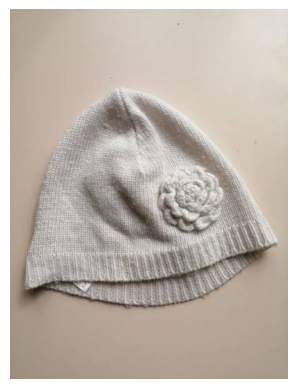

['a white knit hat with a flower on it']
**Adorable White Knit Hat with Flower**

This adorable white knit hat is perfect for adding a touch of sweetness to your winter look. The soft, cozy knit is perfect for keeping your head warm, and the delicate flower embellishment adds a touch of feminine charm. Whether you're running errands or just relaxing at home, this hat is sure to make you feel stylish and put-together.

**Features:**

* Soft, cozy knit
* Delicate flower embellishment
* One size fits most
* Machine-washable

**Benefits:**

* Keeps your head warm
* Adds a touch of sweetness to your winter look
* Makes you feel stylish and put-together

**How to wear:**

This hat can be worn with a variety of winter outfits. Pair it with a cozy sweater and jeans for a casual look, or dress it up with a dress and heels for a more formal occasion. You can also wear it with a scarf or beanie for extra warmth.

**Where to wear:**

This hat is perfect for wearing to school, work, or running erra

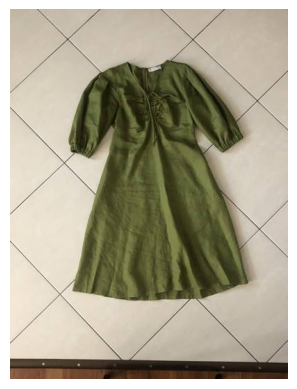

['a green dress hanging on a wall']
**A modern, minimalist dress that is perfect for any occasion.**

This green dress is made from a lightweight, breathable fabric that will keep you cool and comfortable all day long. The fitted bodice and flared skirt create a flattering silhouette that will make you look your best. The dress is also fully lined, so you can wear it without a slip.

This dress is perfect for a variety of occasions, from a casual day out to a special event. Pair it with sandals or heels for a stylish look.

**Product Details:**

* Color: Green
* Fabric: Lightweight, breathable fabric
* Fit: Fitted bodice and flared skirt
* Lining: Fully lined
* Occasion: Casual, formal

**Order yours today and see how great you look!**


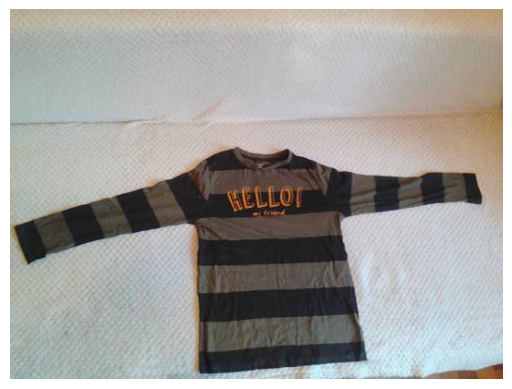

['a shirt that says ` ` ` ` ` ` ` ` ` ` ` ` ` ` `']
**Product Description**

This apparela shirt is a must-have for any man's wardrobe. It's made from high-quality cotton and features a classic fit. The shirt is also wrinkle-resistant, so you can look your best even on the busiest days.

The shirt is available in a variety of colors, so you can find the perfect one to match your style. It's also available in a variety of sizes, so you can find the perfect fit for you.

This shirt is perfect for any occasion, from a casual day out to a night on the town. It's also a great gift for any man in your life.

**Benefits**

* Made from high-quality cotton
* Classic fit
* Wrinkle-resistant
* Available in a variety of colors and sizes
* Perfect for any occasion

**Call to Action**

Order your apparela shirt today and look your best every day.


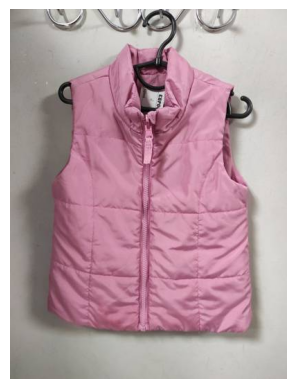

['a pink vest with a black metal hanger']
**Adorable Pink Vest**

This adorable pink vest is the perfect addition to any woman's wardrobe. It's made of a soft, lightweight material that will keep you comfortable all day long. The vest features a flattering V-neckline and a button-down front. It's also fully lined for added warmth.

This vest is perfect for a variety of occasions, from casual wear to date night. You can pair it with jeans, skirts, or dresses. It's also a great layering piece for the cooler months.

This vest is sure to become a staple in your wardrobe. Order yours today!


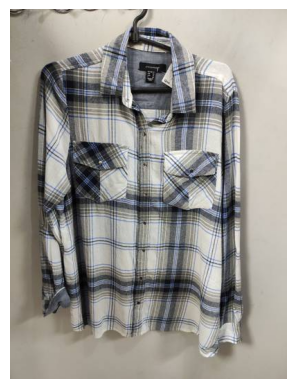

['a white and blue plaid shirt hanging on a wall']
**A classic plaid shirt that will never go out of style.**

This white and blue plaid shirt is a must-have for any man's wardrobe. It's made from a soft, breathable cotton fabric that will keep you comfortable all day long. The classic plaid pattern is timeless and will never go out of style. This shirt is perfect for casual wear, but can also be dressed up for a more formal occasion.

**Features:**

* Soft, breathable cotton fabric
* Classic plaid pattern
* Button-down front
* Long sleeves
* Two chest pockets
* Regular fit

**Care Instructions:**

* Machine wash cold
* Tumble dry low
* Do not iron

**Order yours today and experience the comfort and style of a classic plaid shirt!**


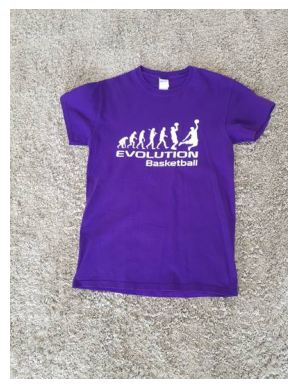

['a purple shirt with the evolution logo on it']
**Evolution Purple T-Shirt**

This Evolution purple T-shirt is a must-have for any fan of the brand. It's made from soft, breathable cotton and features the iconic Evolution logo in white. The relaxed fit is perfect for everyday wear, and the shirt can be dressed up or down depending on the occasion.

**Features:**

* Soft, breathable cotton
* Relaxed fit
* Signature Evolution logo
* Machine-washable

**Benefits:**

* Comfortable and stylish
* Perfect for everyday wear
* Shows your support for Evolution

**Call to action:**

Add this Evolution purple T-shirt to your cart today and start showing your support for the brand!


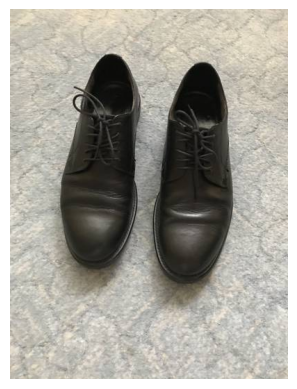

['a pair of black leather shoes']
**A pair of black leather shoes that will make you look sharp and stylish.**

These shoes are made from high-quality leather and are built to last. They feature a sleek design that will complement any outfit. The rubber sole provides excellent traction, making them perfect for everyday wear.

Whether you're running errands, going to work, or out on the town, these shoes will make you look your best. Order your pair today!


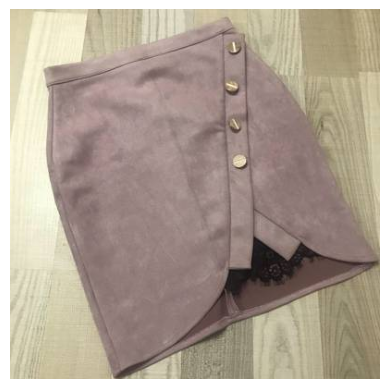

['a purple skirt with a black lace trim']
A purple skirt with a black lace trim is a must-have for any woman's wardrobe. It is a versatile piece that can be dressed up or down, depending on the occasion. The skirt is made of a soft, stretchy fabric that will keep you comfortable all day long. It features a high waist and a flared hem, which is flattering to all body types. The black lace trim adds a touch of sophistication to the skirt, making it perfect for any special event.

Here are some additional details about the product:

* The skirt is available in sizes XS-XL.
* It is machine-washable and dryer-safe.
* The skirt is priced at \$59.99.

If you are looking for a stylish and versatile skirt, then this purple skirt with a black lace trim is the perfect choice for you. It is sure to become a staple in your wardrobe and you will reach for it again and again.


In [10]:
from matplotlib import pyplot as plt

for i in range(1, 9):
    image_data = read_jpeg_image_from_gcs(
        GCS_BUCKET, "product_img/fashion" + str(i) + ".jpeg"
    )
    # Display the image
    plt.imshow(image_data)
    plt.axis("off")
    plt.show()

    instances = [
        {"image": image_to_base64(image_data)},
    ]
    preds = endpoint.predict(instances=instances).predictions
    print(preds)
    product_description = generate_product_description(
        model=generation_model, image_caption=preds[0]
    )
    print(product_description)